In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 83.20%
Success Probability Vector:
tensor([9.5215e-01, 1.3227e-03, 1.8500e-02, 3.8520e-03, 2.8781e-03, 8.8865e-04,
        2.0543e-03, 9.7565e-04, 1.1559e-02, 5.8227e-03], device='cuda:0')
Class 2 - Accuracy: 91.50%
Success Probability Vector:
tensor([1.7414e-03, 9.7952e-01, 1.1444e-03, 3.4956e-04, 1.9705e-04, 2.3211e-04,
        6.4262e-04, 2.5910e-04, 4.0527e-03, 1.1864e-02], device='cuda:0')
Class 3 - Accuracy: 75.90%
Success Probability Vector:
tensor([7.9064e-03, 4.4788e-04, 9.5124e-01, 8.6382e-03, 1.2483e-02, 6.0264e-03,
        9.1820e-03, 2.0276e-03, 1.1539e-03, 8.9623e-04], device='cuda:0')
Class 4 - Accuracy: 70.20%
Success Probability Vector:
tensor([1.9850e-03, 6.4255e-04, 1.1554e-02, 9.1095e-01, 9.0904e-03, 4.3720e-02,
        1.0808e-02, 6.6659e-03, 1.1868e-03, 3.4003e-03], device='cuda:0')
Class 5 - Accuracy: 79.60%
Success Probability Vector:
tensor([2.1857e-03, 3.7064e-04, 1

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.2868433701713079e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.3827927213374332e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.4459622150821724e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 1.3111204991099186e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Successful): Mean = 1.0, Variance = 1.5185742203646657e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.4951002904182889e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.2974247175066454e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.794299750080175e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.4702425203

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[89.0, 91.0, 74.0, 85.0, 86.0, 83.0, 72.0, 87.0, 81.0, 84.0, 81.0, 85.0, 88.0, 88.0, 80.0, 86.0, 72.0, 85.0, 86.0, 71.0, 79.0, 82.0, 87.0, 81.0, 86.0, 86.0, 85.0, 86.0, 83.0, 84.0, 81.0, 77.0, 82.0, 83.0, 74.0, 77.0, 74.0, 73.0, 81.0, 82.0, 83.0, 80.0, 84.0, 76.0, 78.0, 85.0, 86.0, 76.0, 90.0, 85.0, 81.0, 84.0, 94.0, 88.0, 87.0, 85.0, 82.0, 82.0, 77.0, 83.0, 82.0, 91.0, 86.0, 92.0, 76.0, 71.0, 87.0, 81.0, 80.0, 79.0, 87.0, 79.0, 78.0, 91.0, 85.0, 79.0, 79.0, 79.0, 90.0, 85.0, 86.0, 88.0, 88.0, 81.0, 77.0, 81.0, 81.0, 80.0, 76.0, 81.0, 78.0, 83.0, 88.0, 83.0, 87.0, 92.0, 85.0, 85.0, 91.0, 79.0]
Before min/max/mean/std of accuracy
71.0 94.0 82.7 5.02


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 200, 1: 100, 9: 200}, 1: {1: 100, 6: 300, 8: 100}, 2: {1: 100, 3: 200, 6: 100, 8: 100}, 3: {1: 100, 3: 100, 4: 100, 7: 200}, 4: {0: 100, 4: 200, 5: 100, 7: 100}, 5: {0: 200, 1: 100, 4: 100, 5: 100}, 6: {2: 200, 5: 100, 6: 100, 9: 100}, 7: {3: 100, 4: 100, 5: 100, 6: 100, 8: 100}, 8: {2: 100, 3: 100, 7: 100, 8: 200}, 9: {0: 100, 4: 100, 6: 100, 7: 200}, 10: {3: 100, 4: 200, 6: 100, 7: 100}, 11: {7: 400, 9: 100}, 12: {0: 200, 1: 100, 8: 100, 9: 100}, 13: {0: 100, 1: 100, 8: 200, 9: 100}, 14: {0: 100, 3: 100, 4: 100, 5: 100, 8: 100}, 15: {1: 100, 4: 200, 7: 100, 9: 100}, 16: {2: 100, 5: 300, 6: 100}, 17: {1: 100, 7: 100, 9: 300}, 18: {1: 100, 6: 100, 7: 100, 9: 200}, 19: {2: 400, 3: 100}, 20: {2: 100, 3: 100, 4: 200, 7: 100}, 21: {1: 100, 3: 100, 4: 100, 5: 100, 6: 100}, 22: {1: 200, 7: 100, 8: 100, 9: 100}, 23: {0: 100, 5: 200, 6: 100, 7: 100}, 24: {5: 200, 6: 100, 7: 200}, 25: {3: 100, 5: 100, 7: 100, 8: 100, 9: 100}, 26: {2

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 40, 1: 20, 9: 40}, 1: {1: 20, 6: 60, 8: 20}, 2: {1: 20, 3: 40, 6: 20, 8: 20}, 3: {1: 20, 3: 20, 4: 20, 7: 40}, 4: {0: 20, 4: 40, 5: 20, 7: 20}, 5: {0: 40, 1: 20, 4: 20, 5: 20}, 6: {2: 40, 5: 20, 6: 20, 9: 20}, 7: {3: 20, 4: 20, 5: 20, 6: 20, 8: 20}, 8: {2: 20, 3: 20, 7: 20, 8: 40}, 9: {0: 20, 4: 20, 6: 20, 7: 40}, 10: {3: 20, 4: 40, 6: 20, 7: 20}, 11: {7: 80, 9: 20}, 12: {0: 40, 1: 20, 8: 20, 9: 20}, 13: {0: 20, 1: 20, 8: 40, 9: 20}, 14: {0: 20, 3: 20, 4: 20, 5: 20, 8: 20}, 15: {1: 20, 4: 40, 7: 20, 9: 20}, 16: {2: 20, 5: 60, 6: 20}, 17: {1: 20, 7: 20, 9: 60}, 18: {1: 20, 6: 20, 7: 20, 9: 40}, 19: {2: 80, 3: 20}, 20: {2: 20, 3: 20, 4: 40, 7: 20}, 21: {1: 20, 3: 20, 4: 20, 5: 20, 6: 20}, 22: {1: 40, 7: 20, 8: 20, 9: 20}, 23: {0: 20, 5: 40, 6: 20, 7: 20}, 24: {5: 40, 6: 20, 7: 40}, 25: {3: 20, 5: 20, 7: 20, 8: 20, 9: 20}, 26: {2: 20, 3: 20, 9: 60}, 27: {0: 40, 7: 40, 9: 20}, 28: {1: 20, 2: 40, 3: 20, 6: 20}, 29: {0: 20, 1: 40,

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.0319, -0.0008,  0.1063, -0.0185, -0.0100,  0.0121, -0.0045, -0.1176,
         0.0282, -0.0080], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([67.7142, 70.8609, 65.0704, 64.1704, 69.4582, 66.3392, 69.7835, 69.6544,
        69.2276, 69.6032], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0559, -0.1064, -0.1668, -0.1274, -0.1923, -0.1783, -0.1460,
          0.0544, -0.0871],
        [-0.0559,  1.0000, -0.1552, -0.1775, -0.2169, -0.1910, -0.1565, -0.1486,
         -0.0272,  0.1004],
        [-0.1064, -0.1552,  1.0000, -0.0539, -0.0808, -0.0782, -0.0612, -0.1303,
         -0.1343, -0.1619],
        [-0.1668, -0.1775, -0.0539,  1.0000, -0.0667,  0.0180, -0.0392, -0.1142,
         -0.1570, -0.2018],
        [-0.1274, -0.2169, -0.0808, -0.0667,  1.0000, -0.0507, -0.0567, -0.0046,
         -0.1733, -0.2

Weight norm of each class part of classifier
tensor([8.2289, 8.4179, 8.0666, 8.0106, 8.3342, 8.1449, 8.3537, 8.3459, 8.3203,
        8.3429], device='cuda:0', grad_fn=<SqrtBackward0>)


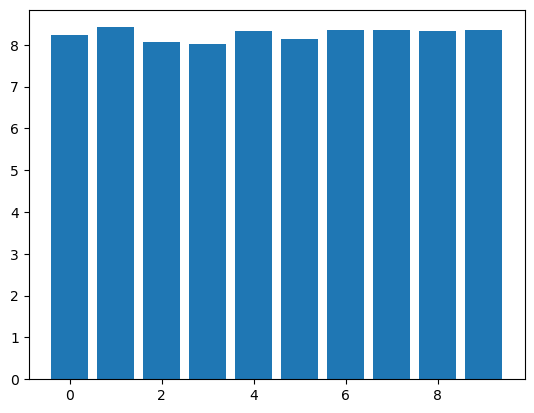

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

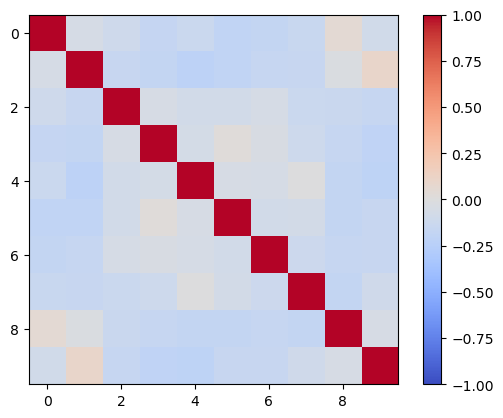

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.87581784, 1: 0.9359081, 2: 0.832171, 3: 0.8203845, 4: 0.85829276, 5: 0.84772414, 6: 0.917415, 7: 0.89078325, 8: 0.9326763, 9: 0.9173337}
-------------------VAR-------------------
{0: 0.03515609, 1: 0.02554984, 2: 0.048143614, 3: 0.039532624, 4: 0.037713308, 5: 0.034251142, 6: 0.030341823, 7: 0.032558057, 8: 0.029713264, 9: 0.035812385}


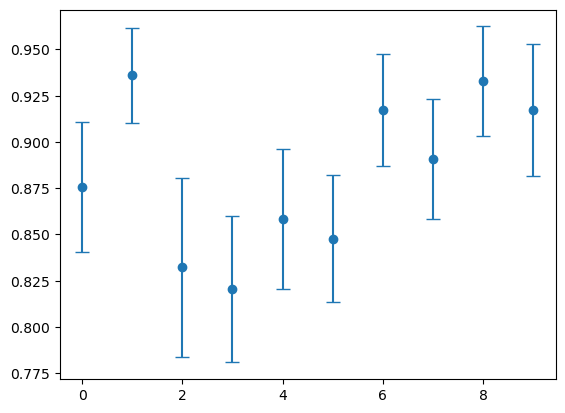

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([5.2520e-02, 1.5778e-03, 8.9855e-02, 3.7011e-03, 3.3017e-03, 0.0000e+00,
        5.4420e-03, 6.0567e-02, 7.1560e-02, 6.2846e-06, 5.5306e-03, 7.4044e-03,
        1.8783e-02, 1.0950e-02, 2.1603e-03, 5.2506e-03, 3.4487e-02, 7.6438e-02,
        3.6973e-03, 2.8470e-03, 3.5263e-03, 3.9294e-02, 5.2187e-03, 3.1497e-03,
        2.7886e-02, 2.1446e-03, 1.0036e-02, 3.4700e-02, 1.7508e-03, 0.0000e+00,
        5.4424e-03, 2.0486e-03, 1.1867e-01, 2.0312e-03, 1.0754e-02, 1.7117e-06,
        7.3848e-04, 2.9920e-04, 9.7451e-05, 8.8621e-03, 1.8312e-01, 0.0000e+00,
        6.1010e-03, 2.5284e-02, 4.7586e-02, 9.0836e-02, 9.3637e-04, 1.1898e-02,
        1.0286e-02, 8.1056e-03, 3.6444e-03, 3.3945e-03, 8.7018e-03, 1.6847e-02,
        2.5734e-02, 2.4068e-03, 2.9667e-03, 1.7665e-02, 1.3935e-02, 4.0851e-03,
        4.6659e-02, 2.0781e-03, 1.1670e-02, 7.2501e-05, 2.2687e-02, 1.2190e-02,
        3.5645e-03, 2.5481e-03, 6.5126e-

# Cosine Similarity of Centroid Vectors

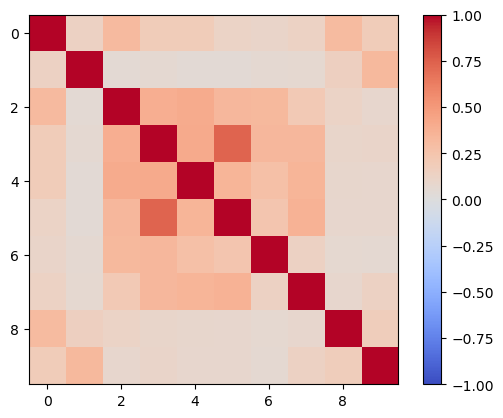

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.0000001  0.13410519 0.3143027  0.18087076 0.18407962 0.12141801
  0.10905243 0.12656559 0.3056168  0.18239105]
 [0.13410519 0.9999999  0.04760361 0.06098022 0.04113662 0.04306295
  0.05545556 0.06324977 0.15350951 0.32625818]
 [0.3143027  0.04760361 1.         0.3838848  0.40196717 0.334634
  0.3233057  0.20834704 0.12109704 0.08008844]
 [0.18087076 0.06098022 0.3838848  1.         0.40744007 0.7297583
  0.32936478 0.33300248 0.10034439 0.10208385]
 [0.18407962 0.04113662 0.40196717 0.40744007 1.         0.35132697
  0.2775367  0.35014242 0.09047154 0.082003  ]
 [0.12141801 0.04306295 0.334634   0.7297583  0.35132697 1.
  0.238522   0.3663718  0.07969431 0.08367006]
 [0.10905243 0.05545556 0.3233057  0.32936478 0.2775367  0.238522
  1.0000001  0.13894658 0.07001181 0.0571993 ]
 [0.12656559 0.06324977 0.20834704 0.33300248 0.35014242 0.3663718
  0.13894658 1.         0.08016295 0.13470024]
 [0.3056168  0.15350951 0.12109704 0.10034439 0.09047154 0.07969431
  

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.8251, 0.8631, 0.7990, 0.7509, 0.7958, 0.7656, 0.8470, 0.8240, 0.8636,
        0.8612], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.8251, 0.8631, 0.7990, 0.7509, 0.7958, 0.7656, 0.8470, 0.8240, 0.8636,
        0.8612], device='cuda:0', grad_fn=<DiagonalBackward0>)


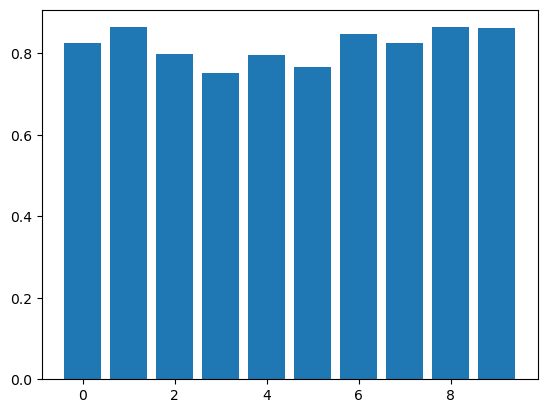

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()